## The SEIR model

In the present notebook, we consider the stochastic version of the SEIR model from the deterministic branch of PyRoss, for more details on the model see *examples/deterministic/ex6-SEIR.ipynb*.

We here

* run and visualise a single simulation of the stochastic SEIR model,
* run 100 stochastic simulations, and calculate mean and standard deviation from the resulting trajectories, and
* compare these to results from the deterministic SEIR model.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

In [2]:
M = 1                  # the SIR model has no age structure
Ni = 1000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

alpha = 0              # fraction of asymptomatic infectives 
beta  = 0.2            # infection rate 
gIa   = 0.1            # recovery rate of asymptomatic infectives 
gIs   = 0.1            # recovery rate of symptomatic infectives 
gE    = 0.04           # recovery rate of E
fsa   = 1              # the self-isolation parameter 

E0  = np.array([0])
Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([15])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0+E0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 500;  Nt=Tf+1;  

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
model = pyross.stochastic.SEIR(parameters, M, Ni)

# simulate model
data=model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt)

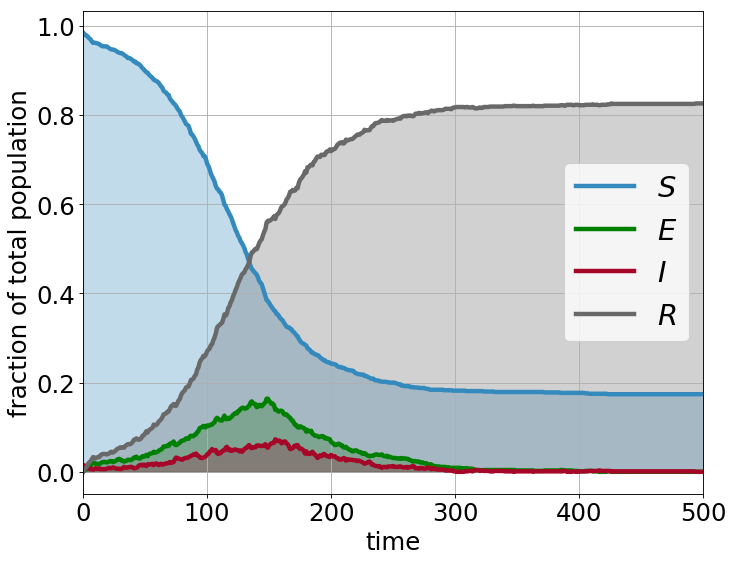

In [3]:
# plot the data and obtain the epidemic curve

S  = data['X'][:,0].flatten()
E  = data['X'][:,1].flatten()
Ia = data['X'][:,2].flatten()
Is = data['X'][:,3].flatten()
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=N-S-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

Note that, since here sample trajectories for the stochastic model are generated, a slightly different plot will result every time the two cells above are run. 


### Averaging over several simulations

If the simulation is run many times, mean and standard deviation of the resulting trajectories can be calculated and compared to the deterministic SIR model.

In [4]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 100
trajectories_s = np.zeros([N_runs,Nt,4],dtype=float)
for i in range(N_runs):
    cur_result = model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt,
                               method='tau-leaping')
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']

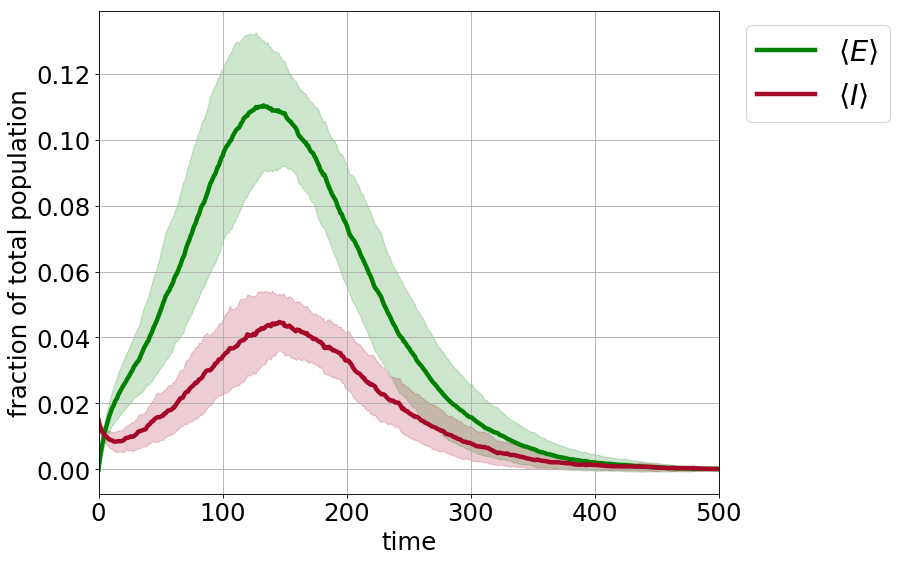

In [5]:
# plot means and standard deviations

mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)

S_s  = mean_s[:,0].flatten()
E_s = mean_s[:,1].flatten()
# I = I_asymptomatic + I_symptomatic
I = np.sum( trajectories_s[:,:,2:], axis = -1)
I_s = np.mean(I,axis=0).flatten()

dS_s = std_s[:,0].flatten()
dE_s = std_s[:,1].flatten()
dI_s =  np.std(I,axis=0).flatten()

# N = S + E + Ia + Is + R 
# =>  R = N - (S + E + Ia + Is)
R_s_trajectories = N - np.sum( trajectories_s, axis =-1) 
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# uncomment next two lines to also plot susceptible population
#plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
#plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)

plt.fill_between(t_s,(E_s - dE_s)/N,(E_s + dE_s)/N,color="green", alpha=0.2)
plt.plot(t_s, E_s/N, '-', color="green", label=r'$\langle E\rangle$', lw=4)

plt.fill_between(t_s,(I_s - dI_s)/N,(I_s + dI_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, I_s/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)

# uncomment next two lines to also plot recovered population
#plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
#plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)

plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.

### Comparison of deterministic simulations with averages over stochastic simulations

In [6]:
# for comparison, we also evaluate the deterministic SEIR model
model_d = pyross.deterministic.SEIR(parameters, M, Ni)
data_d = model_d.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt)

S_d  = data_d['X'][:,0].flatten()
E_d = data_d['X'][:,1].flatten()
Ia_d = data_d['X'][:,2].flatten()
Is_d = data_d['X'][:,3].flatten()
R_d = N - S_d - E_d - Ia_d - Is_d
I_d = Ia_d + Is_d
t_d = data_d['t']

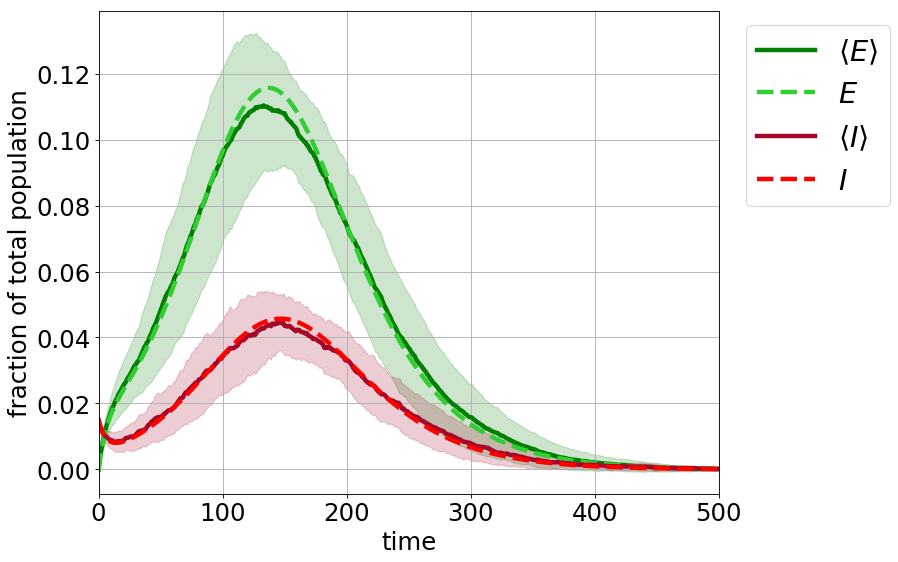

In [7]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# uncomment next two lines to also plot susceptible population
#plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
#plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)

plt.fill_between(t_s,(E_s - dE_s)/N,(E_s + dE_s)/N,color="green", alpha=0.2)
plt.plot(t_s, E_s/N, '-', color="green", label=r'$\langle E\rangle$', lw=4)
plt.plot(t_d,E_d/N,ls='--',color='limegreen',label=r'$E$',lw=4)

plt.fill_between(t_s,(I_s - dI_s)/N,(I_s + dI_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, I_s/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.plot(t_d,I_d/N,ls='--',color='red',label=r'$I$',lw=4)

# uncomment next two lines to also plot recovered population
#plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
#plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)

plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

The dashed colored lines denote the results from the deterministic SEIR model.

For the small population numbers considered here, deviations between deterministic and stochastic simulations can be observed. Running the whole notebook again with a larger total population of, for example, $N=10000$ and an initial symptomatic infective population of $I_{s}(0) = 100$, one will observe very good agreement between stochastic and deterministic model. 